In [385]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [386]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [387]:
filename = 'Population analysis results for video analysis of free interaction.xlsx'
filepath = folder_path = osp.join('..','..','analysis')
full_file_name = osp.join(filepath,'free', filename)
df_dict = pd.read_excel(full_file_name,None)


In [388]:
folder_path = osp.join('..','..','analysis')
path_to_free_enc_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_free.xlsx')

path_to_free_post_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - PostEncounter-PreEncounter_free_4-12_30-80_free.xlsx')

path_to_free_lfp = osp.join(folder_path,
                            'lfp_rawdata_free.xlsx') 

In [389]:
df_free_lfp_raw = pd.read_excel(path_to_free_lfp ,header=[0,1,2], index_col=[0])
df_free_enc_pre = pd.read_excel(path_to_free_enc_pre,None)
df_free_post_pre = pd.read_excel(path_to_free_post_pre,None)


In [390]:
import re

def fix_file_paths(df_files):
    
    df_files = df_files.rename(columns={df_files.columns[1]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files



def extract_ratnum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"rat(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number

def extract_daynum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"day(\d{1,2})", filename.lower())
    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number
# rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]

area_num_to_name_map = {
    '111': 'MeD',
    '2': 'MePV',
    '13':'CeA',
    '112': 'BMA',
    '14': 'AA',
    '16': 'EA',
    '12': 'STIA',
    '15': 'VP'
}



def reformat_columns(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    freqs = df.columns.get_level_values('freq').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    for area in areas:
        for freq in freqs:
            for stage in stages:

                col_name = (area, freq, stage)
                
                area_name = area_num_to_name_map[area]
                if "diffduring" in stage.lower():
                    new_stage = 'enc_pre_lfp'
                elif"diffafter" in stage.lower():
                    new_stage = 'post_pre_lfp'
                else:
                    continue
                
                new_freq = freq.replace('-','_') + 'Hz'
                
                
                new_col_name = '_'.join((area_name, new_freq, new_stage))

                df_new[new_col_name] = df[col_name]
    return df_new


SPIKE_DATA_TYPE_SRC = 'diff'
SPIKE_DATA_TYPE_TARGET = 'spike_diff'

# SPIKE_DATA_TYPE_SRC = 'ratio'
# SPIKE_DATA_TYPE_TARGET = 'spike_ratio'

# SPIKE_DATA_TYPE_SRC = 'spikes_'
# SPIKE_DATA_TYPE_TARGET = 'spike_raw'

def reformat_columns_spikes(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    add_pre_sufix = 'ratio' in SPIKE_DATA_TYPE_TARGET or 'diff' in SPIKE_DATA_TYPE_TARGET
    suffix = 'pre_' if add_pre_sufix else ''
    for area in areas:
        for stage in stages:

            col_name = (area, stage)

            area_name = area_num_to_name_map[area]
            if SPIKE_DATA_TYPE_SRC+"during" in stage.lower():
                new_stage = 'enc_'+suffix+ SPIKE_DATA_TYPE_TARGET
            elif SPIKE_DATA_TYPE_SRC+"after" in stage.lower():
                new_stage = 'post_'+suffix+ SPIKE_DATA_TYPE_TARGET
            elif SPIKE_DATA_TYPE_SRC+"before" in stage.lower():
                new_stage = 'pre_'+ SPIKE_DATA_TYPE_TARGET
            else:
                continue

            

            new_col_name = '_'.join((area_name, new_stage))

            df_new[new_col_name] = df[col_name]
    return df_new

def reformat_columns_spikes_v2(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    add_pre_sufix = 'ratio' in SPIKE_DATA_TYPE_TARGET or 'diff' in SPIKE_DATA_TYPE_TARGET
    suffix = 'enc' if add_pre_sufix else ''
    for area in areas:
        for stage in stages:

            col_name = (area, stage)

            area_name = area_num_to_name_map[area]
            if SPIKE_DATA_TYPE_SRC+"during" in stage.lower():
                during_data = df[col_name].dropna().values
            elif SPIKE_DATA_TYPE_SRC+"after" in stage.lower():
                after_data = df[col_name].dropna().values
            elif SPIKE_DATA_TYPE_SRC+"before" in stage.lower():
                before_data = df[col_name].dropna().values
            else:
                continue

            
        # create new column with calculation
        log_during_change = np.log(during_data) - np.log(before_data)
        
        
        new_stage = 'enc_pre_log_'+ SPIKE_DATA_TYPE_TARGET
        new_col_name = '_'.join((area_name, new_stage))
        df_new[new_col_name] = df[col_name]
        
        log_after_change = np.log(after_data) - np.log(before_data)
        new_stage = 'post_pre_log'+ SPIKE_DATA_TYPE_TARGET
        df_new[new_col_name] = df[col_name]
    return df_new
freq_keywords = {'First': '4_18Hz', 'Second':'30_80Hz'}
stage_keywords = {'During':'enc_pre', 'After':'post_pre'}
substrings_to_remove = ['During', 'After','Before', 'First', 'Second']
ignore_keyworks = ['Norm', 'files']

def remove_columns_with_fewer_values(df, N=5):
    # Get the count of non-null values in each column
    column_counts = df.count()

    # Filter columns based on count condition
    columns_to_remove = column_counts[column_counts < N].index

    # Drop the columns from the DataFrame
    updated_df = df.drop(columns=columns_to_remove)

    return updated_df

def reformat_dict_to_table(df_dict, file_df):
# def reformat_dict_to_table(df_dict, freq_keywords, stage_keywords, ignore_keyworks, substrings_to_remove):
    ret_df_list = []
    for sheet, df in df_dict.items():
        df = df.copy()
        # ignore first and last sheets that contain a summary and list of file names
        if any(substring in sheet for substring in ignore_keyworks): 
            continue
            
        if isinstance(df, str):
            print(df)
            continue
            
        if len(df) == 0:
            continue
        
         # Remove all substrings to keep just the area name
        area_name = sheet
        for sub_string_to_remove in substrings_to_remove:
            area_name = area_name.replace(sub_string_to_remove,'')
        
        for fk, freq in  freq_keywords.items():
            if fk in sheet:
                this_freq = freq_keywords[fk]
            for sk in stage_keywords.keys():
                if sk in sheet:
                    this_stage = stage_keywords[sk]
        
                # Rename all column names to match
        
        for col in df.columns:
            area_pair = [col, area_name]
            area_pair.sort()
            
            df.rename(columns={col:f'{area_pair[0]}_{area_pair[1]}_{this_freq}_{this_stage}'}, inplace=True)
        
        
        df.dropna(axis=1, how='all', inplace=True)
        df = remove_columns_with_fewer_values(df)
        ret_df_list.append(df)
        
    df_ret = pd.concat(ret_df_list,axis=1)
    df_ret['files'] = file_df.values
    return df_ret
                
            


# Fix column names
# change 4-12 to 4-18
def fix_range_name(s):
    return s.replace('4_18','4_12')
# if lfp is in the name, put it at the beggining
# if spike_ratio is in the name, put it at the beginning
def move_suffix_to_apx(s, sfx):
    if sfx in s:
        s = s.replace('_'+sfx, '')
        s = sfx+'_'+s
    return s

# if there is not lfp or skipe ration in the name, add coherence at the befinning
def add_cohherence(s):
    if 'lfp' not in s and 'spike' not in s and ('enc' in s or 'post' in s):
        s = 'coherence_' + s
    return s

# add number to catergorical variables to ensure that they are first
def add_number(s):
    if 'sociability' in s:
        s = '0_' + s
        
    elif 'rat_number' in s:
        s = '1_' + s
        
    elif 'day_number' in s:
        s = '2_' + s
    return s

def add_all_fix_functions(s):
    s = fix_range_name(s)
    s = move_suffix_to_apx(s, 'lfp')
    s = move_suffix_to_apx(s, SPIKE_DATA_TYPE_TARGET)
    s = add_cohherence(s)
#     s = add_number(s)
    return s



In [391]:
df_free_lfp = reformat_columns(df_free_lfp_raw)
df_files_free_bad = pd.read_excel(full_file_name,'Uploaded files', header=None)
df_files_free = fix_file_paths(df_files_free_bad)['lfp']




In [392]:
df_free_enc_pre_rectified = reformat_dict_to_table(df_free_enc_pre, df_files_free)
df_free_enc_post_rectified = reformat_dict_to_table(df_free_post_pre, df_files_free)
df_free = pd.concat([
    df_free_enc_pre_rectified.set_index('files'),
    df_free_enc_post_rectified.set_index('files'),
    df_free_lfp,
],
    axis=1)


df_free['sociability'] = 'free'

all_df = df_free
filenames = all_df.index.to_list()
all_df['rat_number'] = pd.Categorical([extract_ratnum_from_file_name(r) for r in filenames])
all_df['day_number'] = pd.Categorical([extract_daynum_from_file_name(r) for r in filenames])

all_df.rename(columns={c:add_all_fix_functions(c) for c in all_df.columns} , inplace=True)
all_df = all_df.reindex(sorted(all_df.columns), axis=1)

In [393]:
df_interactions = df_dict['ShortVsLongInteractions']
df_intervals = df_dict['ShortVsLongIntervals']
df_interactions_along_time = df_dict['InteractionAlongTime1SecBin']

In [394]:
df_comb = pd.concat([df_interactions,df_intervals], axis=1)
# sns.pairplot(df_comb)

In [395]:
data_interactions = df_interactions.iloc[:,:3].values
data_intervals = df_intervals.iloc[:,:3].values

# data_interactions = df_interactions
# data_intervals = df_intervals


X_behavior = np.concatenate([data_interactions,data_intervals],axis=1)
# X = data_interactions

In [396]:
scaler = StandardScaler()
X_behavior_scaled = scaler.fit_transform(X_behavior)

In [397]:
X_behavior_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_behavior_scaled)

In [398]:
df_sum = pd.DataFrame()
df_sum['sessions'] = df_files_free
df_sum[['tsne1','tsne2']] = X_behavior_embedded

<Axes: xlabel='tsne1', ylabel='tsne2'>

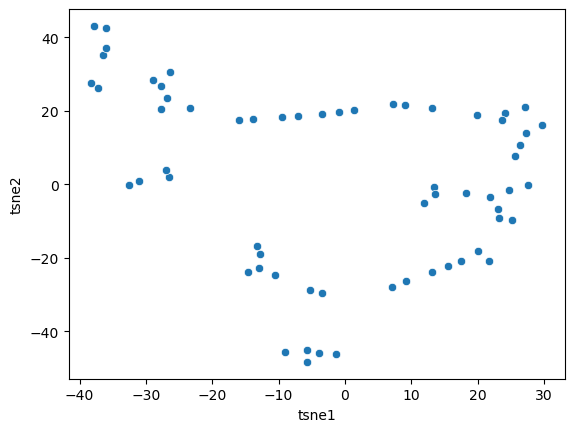

In [399]:
sns.scatterplot(data=df_sum, x='tsne1', y='tsne2')

In [400]:


db = DBSCAN(eps=2, min_samples=2).fit(X_behavior_scaled)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 2


In [401]:
df_sum['dbscan'] = db.fit_predict(X_behavior_scaled)


In [402]:
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='dbscan')

In [403]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
n_components = 2
# kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4, random_state=0)
# bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

# kmeans = KMeans(init="random", n_clusters=2, n_init=2)
# bench_k_means(kmeans=kmeans, name="random", data=data)

pca = PCA(n_components=n_components).fit(X_behavior_scaled)
kmeans = KMeans(init=pca.components_, n_clusters=n_components, n_init=1)
# bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)
df_sum['kmean_labels'] = kmeans.fit_predict(X_behavior_scaled)

kmeans = KMeans(init="random", n_clusters=n_components, n_init=1)
# bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)
df_sum['kmean_labels_tsne'] = kmeans.fit_predict(X_behavior_embedded)
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________


C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [404]:
pca_comp = pca.fit_transform(X_behavior_scaled)
df_sum[['pca1','pca2']] = pca_comp

<Axes: xlabel='umap1', ylabel='umap2'>

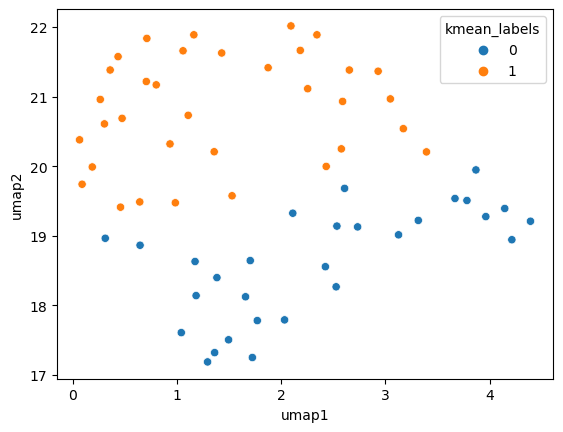

In [405]:
from umap import UMAP
reducer = UMAP()
X_umap = reducer.fit_transform(X_behavior_scaled)
df_sum[['umap1','umap2']] = X_umap
sns.scatterplot(data=df_sum, x='umap1', y='umap2', hue='kmean_labels')

<Axes: xlabel='tsne1', ylabel='tsne2'>

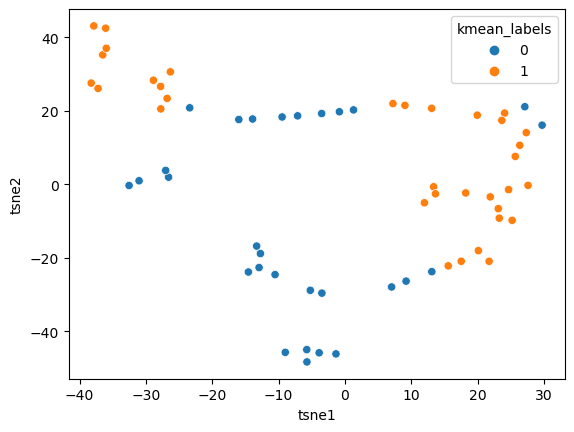

In [406]:
sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='kmean_labels')

In [407]:
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='kmean_labels_tsne')

In [408]:
import pickle
folder_path = folder_path = osp.join('..','..','analysis')
best_model_path = osp.join(folder_path,'best_model_20230626.sav')
# best_model_path = osp.join(folder_path,'best_model.sav')
# best_imputer_path = osp.join(folder_path,'best_imputer.sav')

best_model_dict = pickle.load(open(best_model_path, 'rb'))
best_model = best_model_dict['model']
best_imputer = best_model_dict['imputer']
best_params = best_model_dict['params']


In [409]:
best_model_path = osp.join(folder_path,'best_model_top4_20230626.sav')

best_model_dict = pickle.load(open(best_model_path, 'rb'))
best_model = best_model_dict['model']
best_imputer = best_model_dict['imputer']
best_params = best_model_dict['params']
X_imputed = [imp.transform(X_scaled) for imp in best_imputer]
y_pred_prob = [model.predict_proba(x)[:,0] for x, model in zip(X_imputed, best_model)]
y_pred_all = [model.predict(x) for x, model in zip(X_imputed, best_model)]
y_pred = np.sum((np.array(y_pred_all)=='affiliative')*1, axis=0)>1
dict_vals = {True:'affiliative', False:'aversive'}
y_pred_mode = [dict_vals[v] for v in y_pred]
y_pred_prob_median = np.median(np.array(y_pred_prob),axis=0)


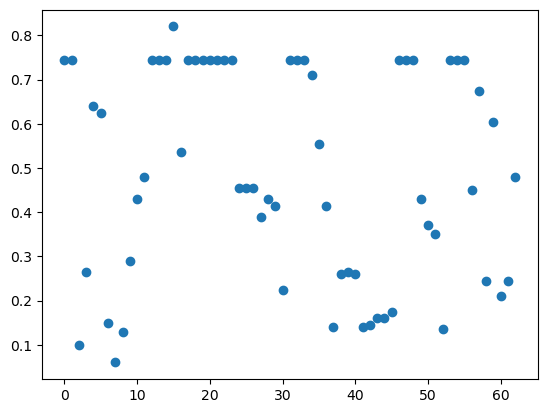

In [410]:
plt.scatter(x=range(len(y_pred_prob_median)), y=y_pred_prob_median)

In [411]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
# best_imputer = IterativeImputer()

In [412]:
best_params

['lfp_EA_30_80Hz_enc_pre',
 'lfp_AA_30_80Hz_enc_pre',
 'coherence_CeA_MeD_30_80Hz_post_pre',
 'coherence_AA_MeD_4_12Hz_enc_pre',
 'coherence_CeA_MeD_4_12Hz_enc_pre',
 'coherence_AA_MeD_30_80Hz_enc_pre',
 'coherence_CeA_MeD_4_12Hz_post_pre',
 'coherence_CeA_STIA_30_80Hz_enc_pre']

In [413]:
# best_vars = [
#     'lfp_EA_30_80Hz_enc_pre',
#      'lfp_AA_30_80Hz_enc_pre',
#      'coherence_CeA_MeD_30_80Hz_post_pre',
#      'coherence_AA_MeD_30_80Hz_enc_pre',
#      'coherence_CeA_STIA_30_80Hz_enc_pre',
# ]

# current_vars = [
#     'lfp_EA_30_80Hz_enc_pre',
#      'lfp_AA_30_80Hz_enc_pre',
#      'coherence_CeA_MeD_30_80Hz_post_pre',
#      'coherence_AA_MeD_4_18Hz_enc_pre',
#      'coherence_CeA_MeD_4_18Hz_enc_pre',
#      'coherence_AA_MeD_30_80Hz_enc_pre',
#      'coherence_CeA_STIA_30_80Hz_enc_pre',
#      'lfp_MePV_4_18Hz_post_pre'
#     ]

In [414]:
# all_df[best_params]

In [415]:
# all_df = all_df.sample(frac=1)
X = all_df[best_params].values


In [416]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_imputed = best_imputer.transform(X_scaled)
# X_imputed = best_imputer.fit_transform(X_scaled)
y_pred_prob = best_model.predict_proba(X_imputed)


AttributeError: 'list' object has no attribute 'transform'

In [ ]:
# y_pred_prob

In [ ]:
df_all = pd.concat([df_sum, df_interactions, df_intervals])


In [ ]:
th = 0.59
# y_pred = []
# for a in  y_pred_prob[:,0] :
#     c = 'affiliative' if a>th else 'aversive'
#     y_pred.append(c)
df_sum['model_pred'] = y_pred_mode

# change label names
labels_map = {1:'affiliative', 0:'aversive'}
df_sum['kmean_labels_labeled'] = df_sum['kmean_labels'].apply(lambda x: labels_map[x])
df_sum['kmean_labels_tsne_labeled'] = df_sum['kmean_labels_tsne'].apply(lambda x: labels_map[x])

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 10.5)
# sns.scatterplot(ax=ax1, data=df_sum, x='tsne1', y='tsne2', hue='kmean_labels_labeled')
# # sns.scatterplot(ax=ax2, data=df_sum, x='tsne1', y='tsne2', hue='model_pred')
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='model_pred')

# var1 = 'Less Than 6 sec'
# var2 = 'More than 6 sec'

var1 = 'tsne1'
var2 = 'tsne2'

sns.scatterplot(ax=ax1, data=df_sum, x=var1, y=var2, hue='kmean_labels_labeled')
# sns.scatterplot(ax=ax2, data=df_sum, x='tsne1', y='tsne2', hue='model_pred')
sns.scatterplot(data=df_sum, x=var1, y=var2, hue='model_pred')

plt.plot()

In [ ]:
# df_sum

In [ ]:
import ipywidgets as widgets
%matplotlib inline


In [ ]:
plt.scatter(x=range(len(y_pred_prob[:, 0])) , y=y_pred_prob[:, 0])

In [ ]:
# y_pred_prob[:,0]

In [ ]:
df_sum.columns

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# To display the plots directly in the Jupyter Notebook
%matplotlib inline


var1 = 'tsne1'
var2 = 'tsne2'

# Set the initial threshold value
initial_threshold = 0.59

# Create a slider widget
slider = widgets.FloatSlider(min=0.0, max=1, step=0.001, value=initial_threshold)

# Define the update function
def update_plot(threshold):
    y_pred = []
    for a in y_pred_prob[:, 0]:
        c = 'affiliative' if a > threshold else 'aversive'
        y_pred.append(c)

    # Update the 'model_pred' column in the DataFrame
    df_sum['model_pred'] = y_pred

    # Clear the previous plot
#     plt.clf()

    # Create a new figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)

    # Update the plot data and properties
    sns.scatterplot(ax=ax1, data=df_sum, x=var1, y=var2, hue='kmean_labels_labeled', palette={'affiliative': 'blue', 'aversive': 'orange', 'between': 'green'})
    sns.scatterplot(ax=ax2, data=df_sum, x=var1, y=var2, hue='model_pred', palette={'affiliative': 'blue', 'aversive': 'orange'})

    # Show the updated plot
    plt.show()

# Register the update function to the slider's value change event
widgets.interact(update_plot, threshold=slider)

# Display the slider
display(slider)



In [ ]:

# df_sum[['tsne21','tsne22']] = embedded_interactions

In [ ]:
# sns.scatterplot(data=df_sum, x='tsne21', y='tsne22',hue='model_pred')

In [ ]:
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2',hue='model_pred')

In [ ]:
# plt.scatter(x=X_embedded[:,0], y=y_pred_prob[:,0])

In [ ]:
best_params

In [ ]:
y_pred_labels = np.array(df_sum['model_pred'])=='affiliative'
# y_pred_labels

In [ ]:
kmean_labels_logic = df_sum['kmean_labels']==0

# kmean_labels_logic

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(kmean_labels_logic, y_pred_labels)
f1

In [ ]:
from sklearn.metrics import cohen_kappa_score
cappa  = cohen_kappa_score(kmean_labels_logic, y_pred_labels)
cappa

In [ ]:
np.sum(kmean_labels_logic == y_pred_labels)

In [ ]:
len(kmean_labels_logic)

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(kmean_labels_logic, y_pred_prob[:,0])
auc

Text(0, 0.5, 'True Positive Rate')

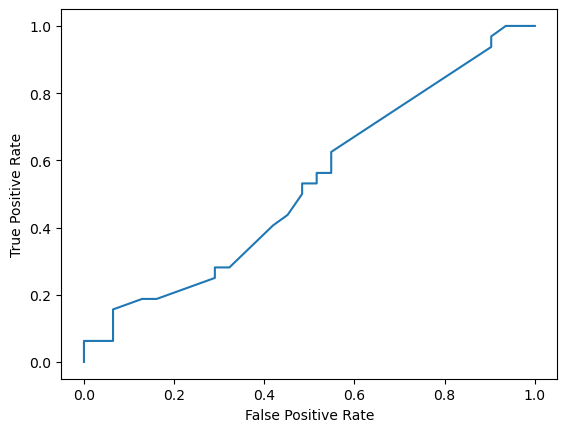

In [172]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


fpr, tpr, thresholds = roc_curve(kmean_labels_logic, y_pred_prob[:,0])
gmean = np.sqrt(tpr * (1 - fpr))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

In [ ]:
import plotly.express as px


In [ ]:
import re


def extract_ratnum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"rat(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number

def extract_daynum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"day(\d{1,2})", filename.lower())
    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number
# rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]

df = df_sum
df['rat_number'] = df['sessions'].apply(extract_ratnum_from_file_name)
df['day_number'] = df['sessions'].apply(extract_daynum_from_file_name)






In [ ]:
df_sum['y_pred_prob'] = y_pred_prob[:,0]


In [ ]:
df_sum.to_clipboard()

In [ ]:
df_comb = pd.concat([df_interactions,df_intervals, df_sum], axis=1)

In [ ]:
# df_comb.to_clipboard()

In [ ]:
df = pd.concat([df_interactions,df_intervals], axis=1)
# df['model_pred'] = df_sum['model_pred']
df['model_pred'] = df_sum['kmean_labels_labeled']
df.index= df_sum['sessions']
df['kmeans'] = df_sum['kmean_labels_labeled'].values
# df['diff_var'] = df['More than 6 sec']>df['More than 6 sec'].median()
df['diff_var'] = (df['Less Than 6 sec']>df['Less Than 6 sec'].median())&(df['Less Than 5 sec']>df['Less Than 5 sec'].median())

In [ ]:
df.columns

In [ ]:
# df = df.drop(['More than 6 sec','More Than 20 sec', 'More Than 19 sec','Less Than 6 sec','Less Than 5 sec'], axis=1)
# vars = ['Less Than 6 sec', 'More than 6 sec','model_pred']
# vars = ['All intervals', 'More than 6 sec','kmeans',]
vars = df.columns

In [ ]:
sns.pairplot(data=df[vars], hue='model_pred', diag_kind='kde')

In [ ]:
# sns.scatterplot( x=df['5 to 20 sec'], y=df['6 to 19 sec'], hue=df['model_pred'])

In [ ]:
df = pd.concat([df_interactions,df_intervals], axis=1)
# df['model_pred'] = df_sum['model_pred']
df['model_pred'] = df_sum['kmean_labels_labeled']
df.index= df_sum['sessions']

df.columns

In [ ]:
# df['diff_var'] = (df['More than 6 sec']>df['More than 6 sec'].median()).values
df['diff_var'] = ((df['6 to 19 sec']>df['6 to 19 sec'].mean())&(df['Less Than 5 sec']>df['Less Than 5 sec'].mean())).values
df[['tsne1','tsne2' ]] = df_sum[['tsne1','tsne2' ]].values
df['model_pred'] = df_sum['model_pred'].values



In [ ]:
# df['More than 6 sec']

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 10.5)
# sns.scatterplot(ax=ax1, data=df_sum, x='tsne1', y='tsne2', hue='kmean_labels_labeled')
# # sns.scatterplot(ax=ax2, data=df_sum, x='tsne1', y='tsne2', hue='model_pred')
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='model_pred')

# var1 = 'Less Than 6 sec'
# var2 = 'More than 6 sec'

var1 = 'tsne1'
var2 = 'tsne2'

sns.scatterplot(ax=ax1, data=df, x=var1, y=var2, hue='diff_var')
# sns.scatterplot(ax=ax2, data=df_sum, x='tsne1', y='tsne2', hue='model_pred')
sns.scatterplot(ax=ax2, data=df, x=var1, y=var2, hue='model_pred')

plt.plot()

In [ ]:
sns.histplot(x=df['diff_var'].values , y=df_sum['model_pred'].values==)

In [ ]:
import sweetviz as sv

In [ ]:
# #EDA using Autoviz
# df_vis = df
# # df_vis = df_vis[[c for c in df_vis.columns if c not in cat_vars]]

# # df_vis = df_vis.apply(pd.to_numeric)
# # df_vis['sociability'] = df_coherence_data['sociability']

# # feature_config = sv.FeatureConfig(force_num=[c for c in df_vis.columns if c not in cat_vars])
# sweet_report = sv.compare_intra(
#     df_vis,df_vis['model_pred']=='affiliative',
#     ['affiliative', 'aversive'],
# #     feat_cfg=feature_config
# )

# #Saving results to HTML file
# sweet_report.show_html('df_free.html')
# # sweet_report.show_notebook(filepath='sweet_report.html')

In [ ]:
df_comb.columns

In [ ]:

df = pd.concat([df_comb, df_sum], axis=1)
df.reset_index()
df.columns

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np
from ipywidgets import interactive, HBox, VBox, Button

py.init_notebook_mode()

var_y = 'tsne2'
var_x = 'tsne1'
hue_column = 'model_pred'

color_mapping = {
    'affiliative': 'red',
    'aversive': 'blue',
}
colors = [color_mapping[val] for val in df[hue_column].values]

values = ['sessions','rat_number','day_number','model_pred','kmean_labels_labeled',
    'Less Than 6 sec', '6 to 19 sec', 'More Than 19 sec', 'More than 6 sec',
       'Total time', 'Less Than 5 sec', '5 to 20 sec', 'More Than 20 sec',
       'All intervals']

f = go.FigureWidget([go.Scatter(y = df[var_y], x = df[var_x], mode = 'markers', marker=dict(
        color=colors,
        colorscale='Viridis',  # Choose the desired color scale
        showscale=True
    ))])
scatter = f.data[0]
N = len(df)
# scatter.x = scatter.x + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
# scatter.y = scatter.y + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
scatter.marker.opacity = 0.5

def update_axes(xaxis, yaxis):
    scatter = f.data[0]
    scatter.x = df[xaxis]
    scatter.y = df[yaxis]
    with f.batch_update():
        f.layout.xaxis.title = xaxis
        f.layout.yaxis.title = yaxis
#         scatter.x = scatter.x + np.random.rand(N)/10 *(df[xaxis].max() - df[xaxis].min())
#         scatter.y = scatter.y + np.random.rand(N)/10 *(df[yaxis].max() - df[yaxis].min())

axis_dropdowns = interactive(
#     update_axes, yaxis = df.select_dtypes('int64').columns, xaxis = df.select_dtypes('int64').columns)
    update_axes, yaxis = df.columns, xaxis = df.columns)

# Create a table FigureWidget that updates on selection from points in the scatter plot of f
go_tab = go.Table(
    header=dict(values=values,
                fill = dict(color='#C2D4FF'),
                align = ['left'] * 5),
    cells=dict(values=[df[col] for col in values],
               fill = dict(color='#F5F8FF'),
               align = ['left'] * 5))
t = go.FigureWidget([go_tab])

def selection_fn(trace,points,selector):
    t.data[0].cells.values = [df.loc[points.point_inds][col] for col in values]
#     print(df.loc[points.point_inds][values])
scatter.on_selection(selection_fn)


def copy_to_clipboard(btn):
    df_selected = df.iloc[list(scatter.selectedpoints)][values]
#     csv_data = df_selected.to_csv(index=False)
#     clipboard.copy(csv_data)
    df_selected.to_clipboard()
    print("Data copied to clipboard")

scatter.on_selection(selection_fn)

# Create the button to copy data to clipboard
copy_button = Button(description='Copy to Clipboard',)
copy_button.on_click(copy_to_clipboard)

# Put everything together
VBox((HBox(axis_dropdowns.children), copy_button, f, t))

In [ ]:
# go_table_vals = go_tab.to_plotly_json()['cells']['values']
# go_table_headers = go_tab.to_plotly_json()['header']['values']
# pd.DataFrame(zip(*go_table_vals), columns=go_table_headers)

In [211]:
df_clusters = pd.read_excel(osp.join(folder_path,'clustering_of_free_rats_based_on_tsne.xlsx'),'clusters')


In [212]:
# df_vis = df_clusters
# # df_vis = df_vis[[c for c in df_vis.columns if c not in cat_vars]]

# # df_vis = df_vis.apply(pd.to_numeric)
# # df_vis['sociability'] = df_coherence_data['sociability']

# # feature_config = sv.FeatureConfig(force_num=[c for c in df_vis.columns if c not in cat_vars])
# sweet_report = sv.compare_intra(
#     df_vis,df_vis['model_pred']=='affiliative',
#     ['affiliative', 'aversive'],
# #     feat_cfg=feature_config
# )

# #Saving results to HTML file
# sweet_report.show_html('df_free.html')
# # sweet_report.show_notebook(filepath='sweet_report.html')

In [213]:
import pandas as pd
from scipy import stats

def compare_groups(df, grouper):
    # Create an empty DataFrame to store the results
    significance_table = pd.DataFrame(columns=['variable', 'statistic', 'pvalue'])
    
    # Iterate over each numeric variable in the DataFrame
    for column in df.select_dtypes(include='number'):
        if column ==grouper:
            continue
        groups = [group[column] for _, group in df.groupby(grouper)]
        
        # Perform the statistical test (e.g., one-way ANOVA)
        statistic, pvalue = stats.f_oneway(*groups)
        
        # Append the results to the significance table
        significance_table = significance_table.append({'variable': column, 'statistic': statistic, 'pvalue': pvalue}, ignore_index=True)
    
    # Sort the significance table by p-value in ascending order
    significance_table = significance_table.sort_values(by='pvalue')
    
    return significance_table


In [214]:
import warnings
with warnings.catch_warnings(record=True):
    sig_tab = compare_groups(df_clusters,grouper='cluster')

In [269]:
top_vars = sig_tab.loc[sig_tab['pvalue']<0.1]['variable'].values
top_vars = list(top_vars)
print(top_vars)
top_vars.append('cluster')


['5 to 20 sec', 'More Than 20 sec', 'All intervals', 'Less Than 5 sec', '6 to 19 sec', 'Less Than 6 sec', 'Total time', 'More than 6 sec', 'More Than 19 sec']


In [270]:
# sns.pairplot(df_clusters[top_vars], hue='cluster', palette=sns.color_palette("bright")[:3])

In [271]:
X_behavior = df_clusters[top_vars].drop('cluster', axis=1).values
scaler = StandardScaler()
X_behavior_scaled = scaler.fit_transform(X_behavior)
X_tsne_embed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10).fit_transform(X_behavior_scaled)
df_clusters[['tsne1','tsne2']] = X_tsne_embed

<Axes: xlabel='tsne1', ylabel='tsne2'>

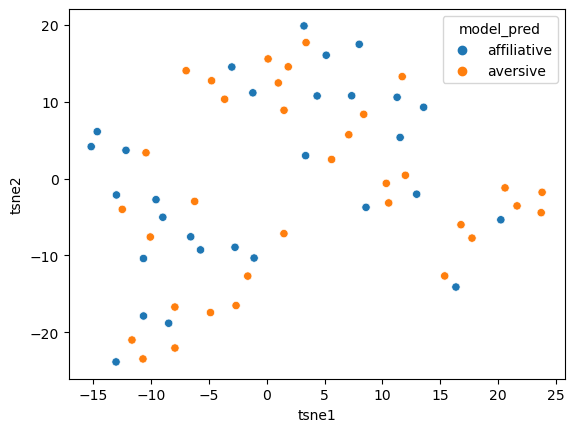

In [272]:
sns.scatterplot(data=df_clusters, x='tsne1', y='tsne2', hue='model_pred')

In [369]:
df_clusters['model_pred'] = y_pred_mode


In [370]:
df_clusters['model_pred']

0     affiliative
1     affiliative
2        aversive
3        aversive
4     affiliative
         ...     
58       aversive
59    affiliative
60       aversive
61       aversive
62    affiliative
Name: model_pred, Length: 63, dtype: object

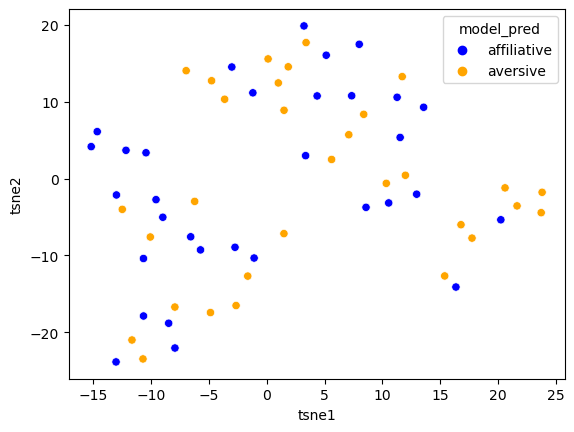

In [313]:
df = df_clusters

var1 = 'tsne1'
var2 = 'tsne2'

# sns.scatterplot(ax=ax1, data=df, x=var1, y=var2, hue='cluster', palette={1: 'blue', 2: 'orange', 3: 'green'})
sns.scatterplot(data=df, x=var1, y=var2, hue='model_pred', palette={'affiliative': 'blue', 'aversive': 'orange'})
plt.show()

In [281]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# To display the plots directly in the Jupyter Notebook
%matplotlib inline


var1 = 'tsne1'
var2 = 'tsne2'
df = df_clusters

# Set the initial threshold value
initial_threshold = 0.59

# Create a slider widget
slider = widgets.FloatSlider(min=0.0, max=1, step=0.001, value=initial_threshold)

# Define the update function
def update_plot(threshold):
    y_pred = []
    for a in y_pred_mean:
        c = 'affiliative' if a > threshold else 'aversive'
        y_pred.append(c)

    # Update the 'model_pred' column in the DataFrame
    df['model_pred'] = y_pred

    # Clear the previous plot
#     plt.clf()

    # Create a new figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)

    # Update the plot data and properties
    sns.scatterplot(ax=ax1, data=df, x=var1, y=var2, hue='cluster', palette={1: 'blue', 2: 'orange', 3: 'green'})
    sns.scatterplot(ax=ax2, data=df, x=var1, y=var2, hue='model_pred', palette={'affiliative': 'blue', 'aversive': 'orange'})

    # Show the updated plot
    plt.show()

# Register the update function to the slider's value change event
widgets.interact(update_plot, threshold=slider)

# Display the slider
display(slider)



interactive(children=(FloatSlider(value=0.59, description='threshold', max=1.0, step=0.001), Output()), _dom_c…

FloatSlider(value=0.59, description='threshold', max=1.0, step=0.001)

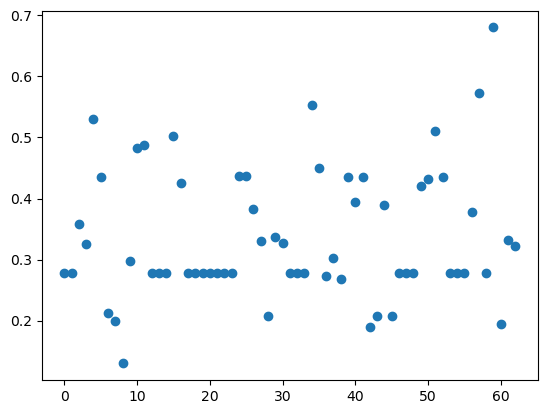

In [283]:
plt.scatter(x=range(len(y_pred_mean)) , y=y_pred_mean)

<Axes: xlabel='tsne1', ylabel='tsne2'>

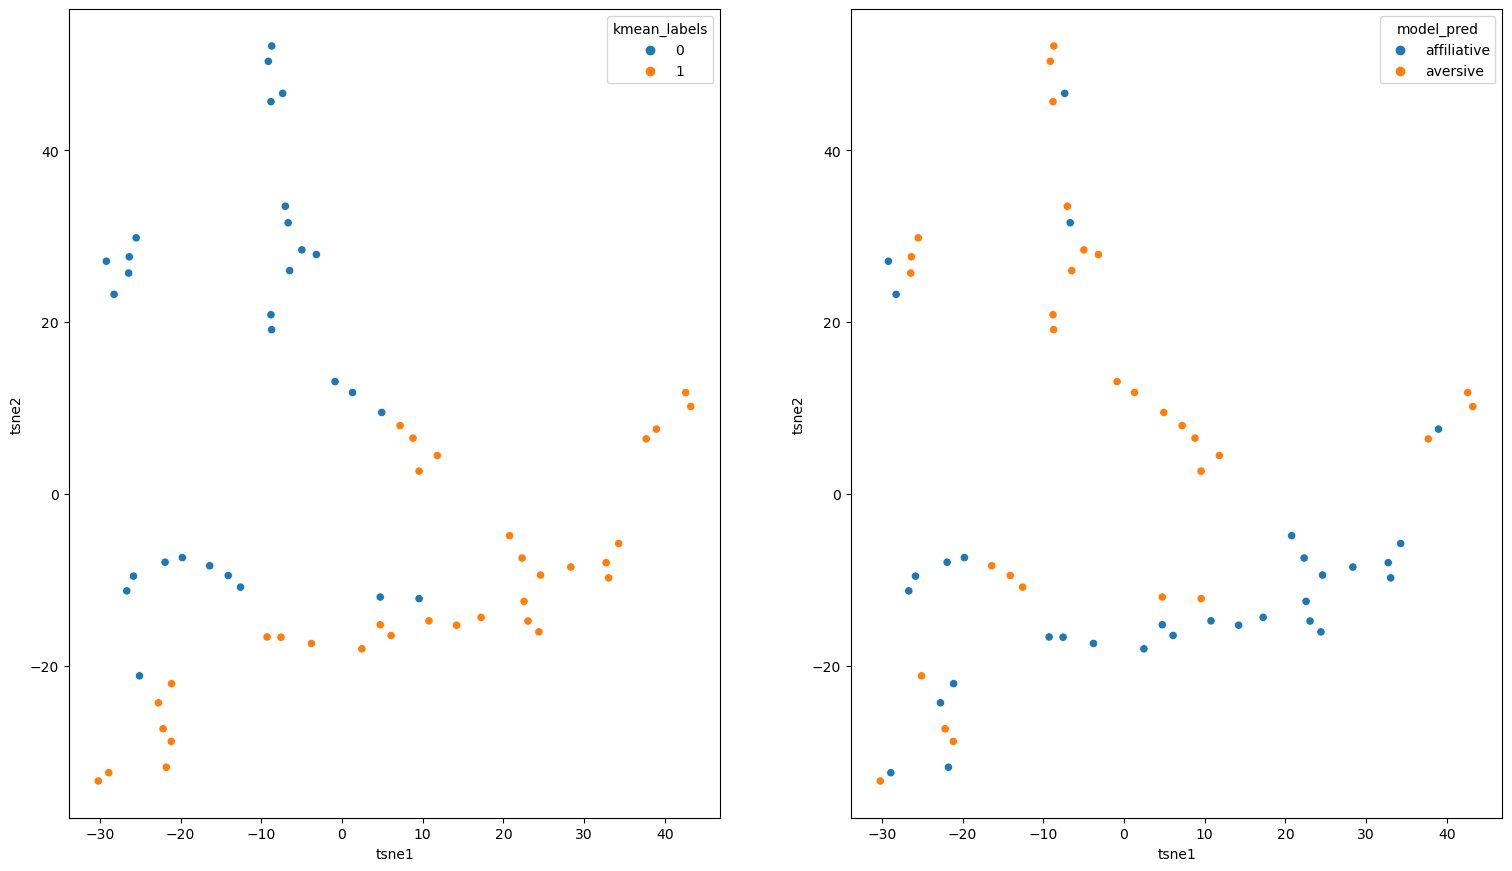

In [372]:
df_sum['model_pred'] = y_pred_mode
# Create a new figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

# Update the plot data and properties
sns.scatterplot(ax=ax1, data=df_sum, x='tsne1', y='tsne2', hue='kmean_labels')
sns.scatterplot(ax=ax2, data=df_sum, x='tsne1', y='tsne2', hue='model_pred')